In [2]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 2.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 536.4 kB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


Choose mode: 1 for random, 2 for interactive, 3 for OSM
Fetching boundary for Seattle, Washington, USA...
Cost: 0.95, Runtime: 36.309s, Memory: 2.95KB


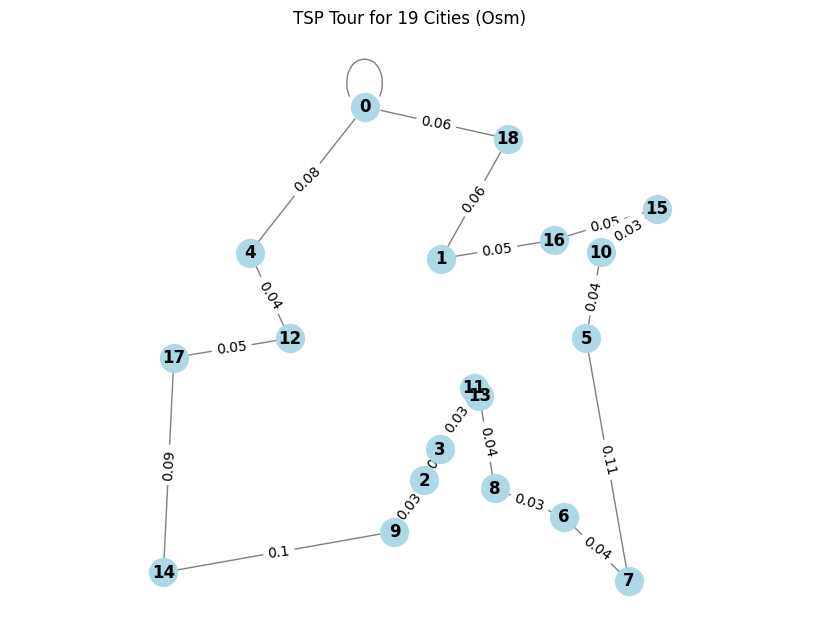


Running complexity analysis...

Testing 1 cities (osm)...
Fetching boundary for Seattle, Washington, USA...
Failed for 1 cities: Failed to find a valid tour.

Testing 3 cities (osm)...
Fetching boundary for Seattle, Washington, USA...
Cost: 0.45, Runtime: 0.000s, Memory: 0.20KB


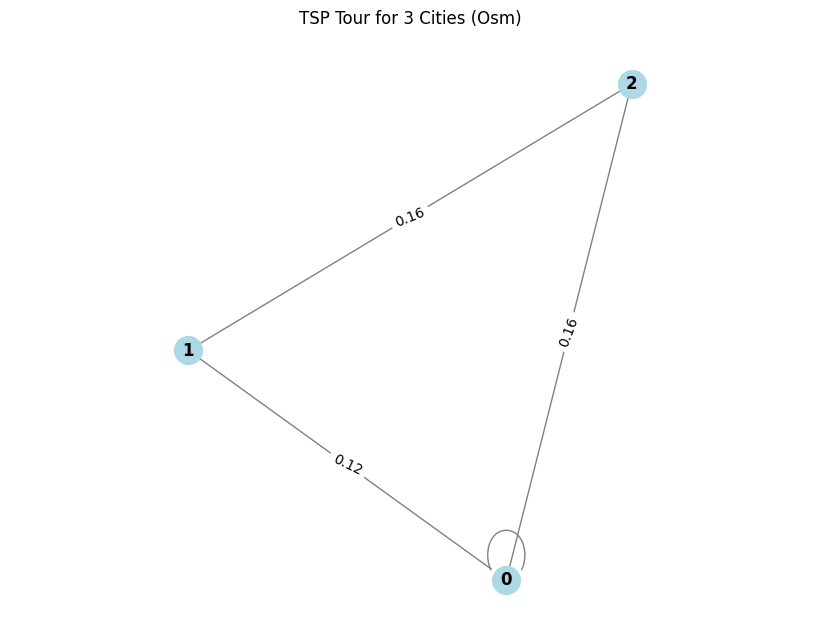


Testing 5 cities (osm)...
Fetching boundary for Seattle, Washington, USA...
Cost: 0.54, Runtime: 0.000s, Memory: 0.32KB


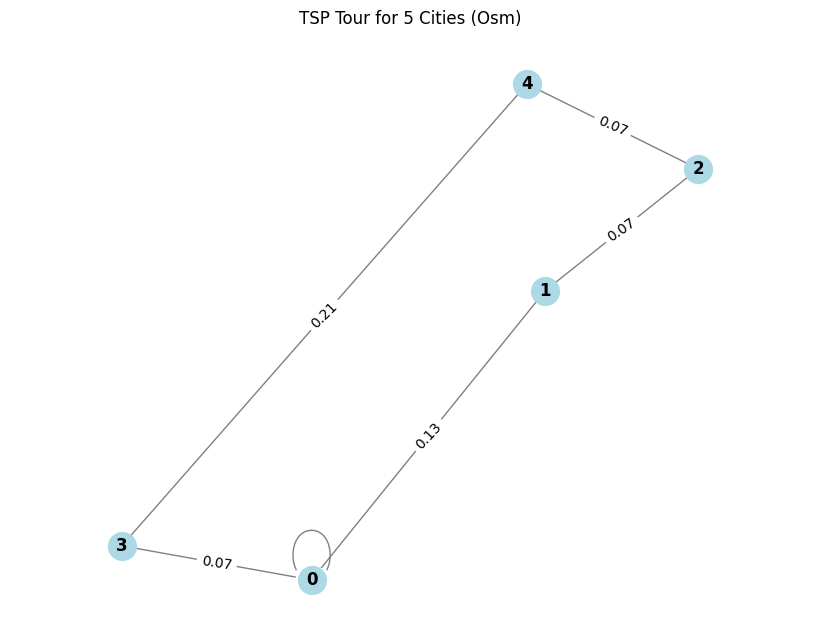


Testing 7 cities (osm)...
Fetching boundary for Seattle, Washington, USA...
Cost: 0.52, Runtime: 0.001s, Memory: 0.51KB


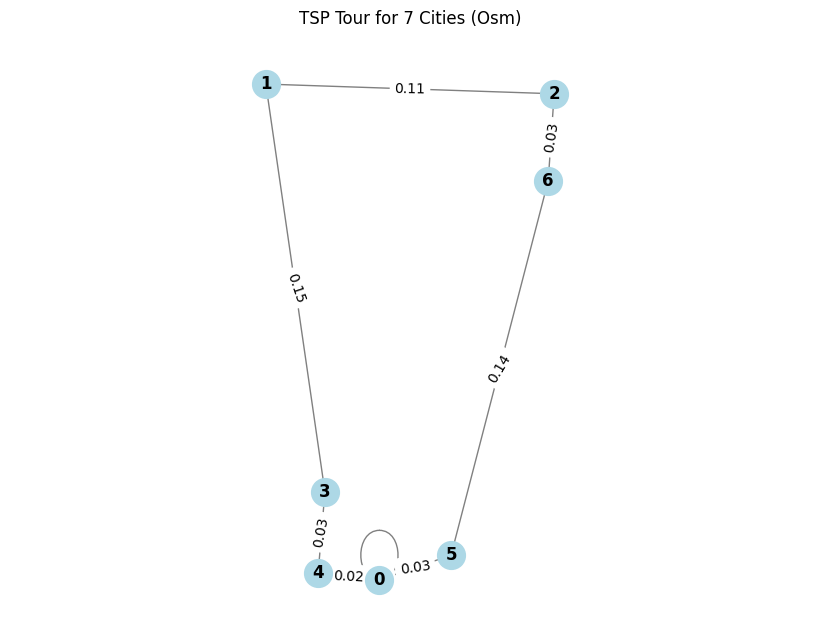


Testing 9 cities (osm)...
Fetching boundary for Seattle, Washington, USA...
Cost: 0.65, Runtime: 0.007s, Memory: 0.76KB


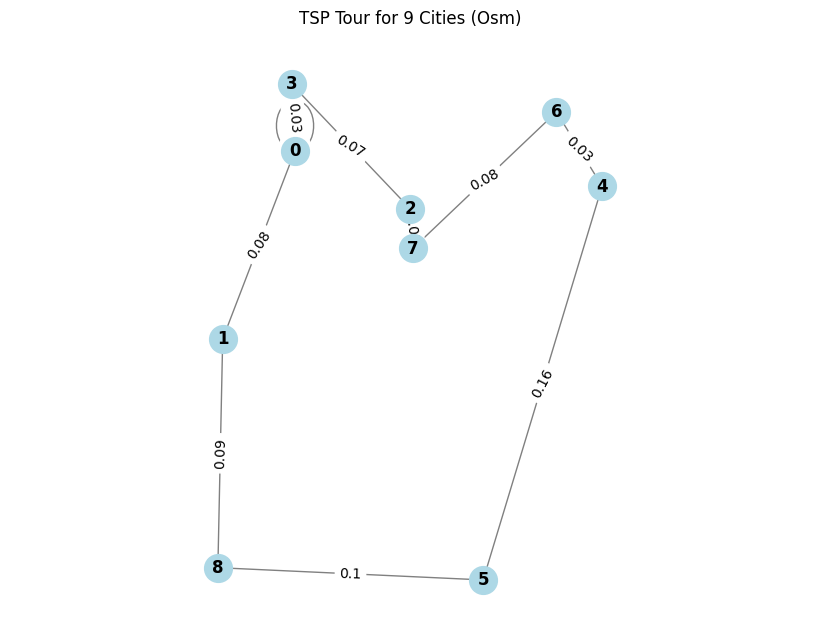


Testing 11 cities (osm)...
Fetching boundary for Seattle, Washington, USA...
Cost: 0.56, Runtime: 0.045s, Memory: 1.07KB


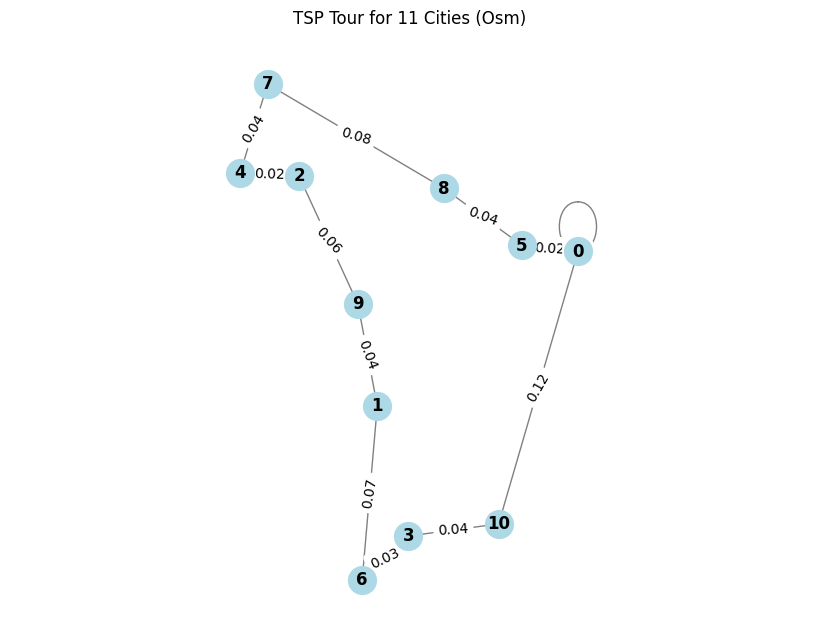


Testing 13 cities (osm)...
Fetching boundary for Seattle, Washington, USA...
Cost: 0.68, Runtime: 0.231s, Memory: 1.45KB


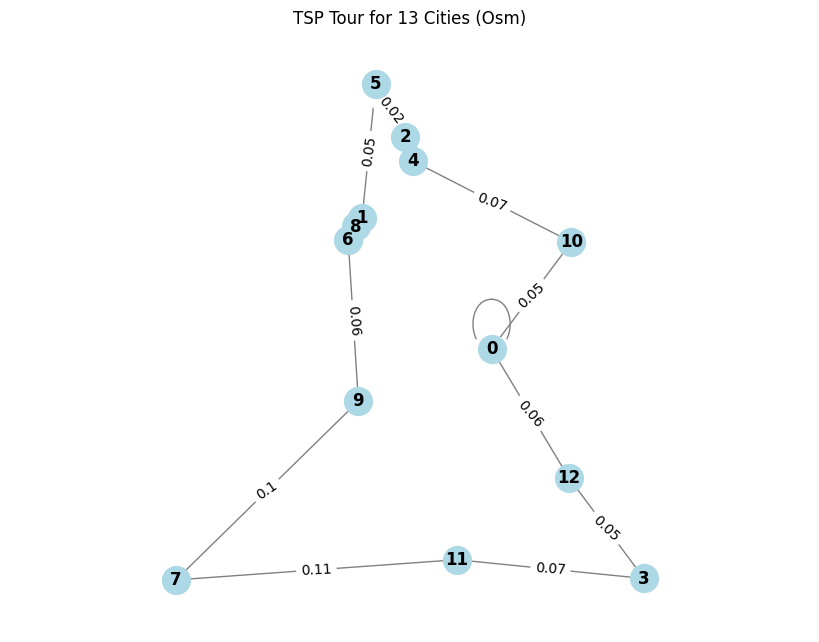


Testing 15 cities (osm)...
Fetching boundary for Seattle, Washington, USA...
Cost: 0.73, Runtime: 1.209s, Memory: 1.88KB


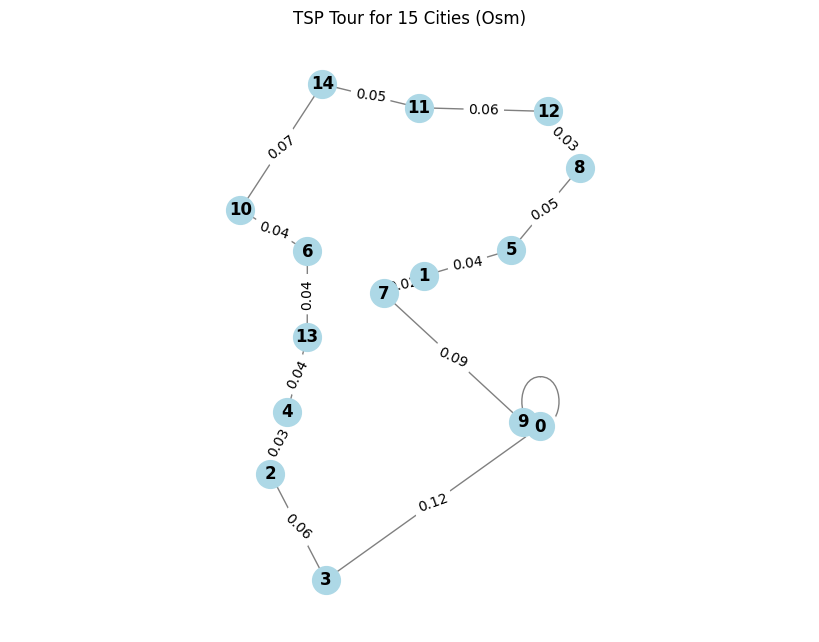


Testing 17 cities (osm)...
Fetching boundary for Seattle, Washington, USA...
Cost: 0.72, Runtime: 7.109s, Memory: 2.38KB


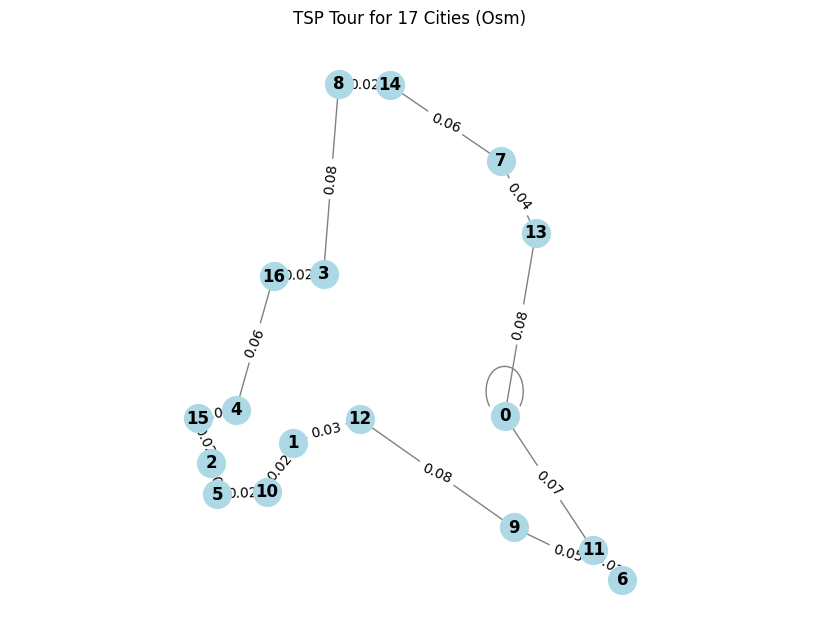

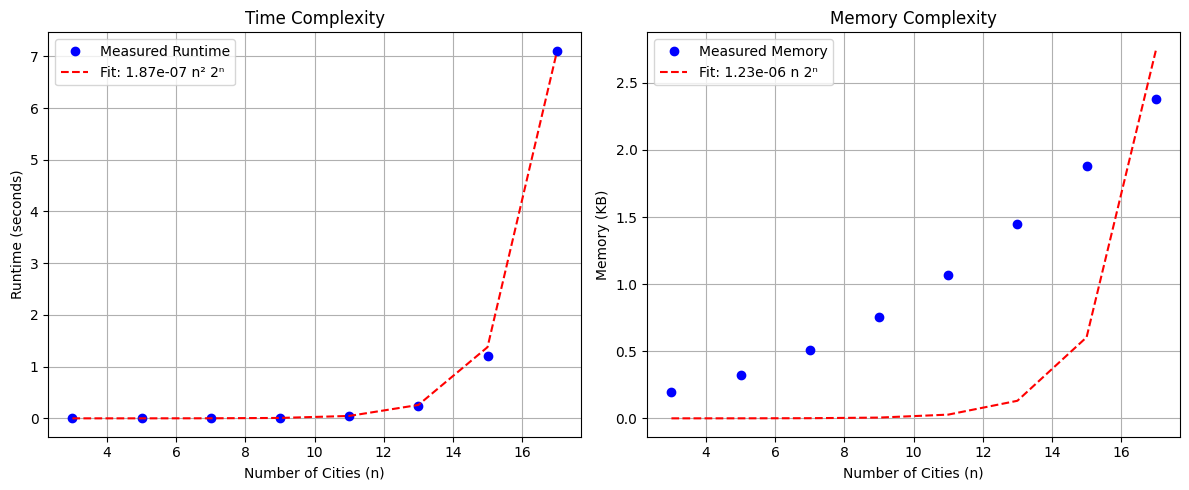

In [4]:
# IMPORT STATMENTS
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import sys
from scipy.optimize import curve_fit
import osmnx as ox
from shapely.geometry import Point

# FUNCTIONS OPTION 1 2 3 

def Dis_M(n, width=640, height=480): 
    
    cities = np.random.rand(n, 2) * [width, height]
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist[i, j] = dist[j, i] = np.linalg.norm(cities[i] - cities[j])
    return dist, cities

def Dis_M_In(n, width=640, height=480):
    # user input distance matrix
    print(f"Enter {n} city coordinates (x, y) between 0-{width} and 0-{height}, one per line.")
    print("Format: 'x y' (e.g., '100 200')")
    cities = []
    for i in range(n):
        while True:
            try:
                x, y = map(float, input(f"City {i+1}: ").split())
                if 0 <= x <= width and 0 <= y <= height:
                    cities.append([x, y])
                    break
                else:
                    print(f"Coordinates must be within 0-{width}, 0-{height}.")
            except ValueError:
                print("Invalid input. Use format 'x y' with numbers.")
    cities = np.array(cities)

    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist[i, j] = dist[j, i] = np.linalg.norm(cities[i] - cities[j])
    return dist, cities

def Dis_M_Osm(n, place_name="Seattle, Washington, USA"):
   # osm based distance matrix
    print(f"Fetching boundary for {place_name}...")
    gdf = ox.geocode_to_gdf(place_name)
    boundary = gdf.geometry.iloc[0]

    cities = []
    minx, miny, maxx, maxy = boundary.bounds
    while len(cities) < n:
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        point = Point(x, y)
        if boundary.contains(point):
            cities.append([x, y])
    cities = np.array(cities)

    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist[i, j] = dist[j, i] = np.linalg.norm(cities[i] - cities[j])
    return dist, cities

def held_karp(dist):
    
    n = len(dist)
    dp = {}
    for i in range(1, n):
        subset = 1 | (1 << i)
        dp[(subset, i)] = (dist[0][i], [0, i])

    for size in range(2, n + 1):
        for subset in range(1 << n):
            if bin(subset).count('1') != size or not (subset & 1):
                continue
            for last in range(1, n):
                if not (subset & (1 << last)):
                    continue
                prev = subset ^ (1 << last)
                min_cost, min_path = float('inf'), None
                for prev_last in range(n):
                    if prev_last == last or not (prev & (1 << prev_last)):
                        continue
                    if (prev, prev_last) not in dp:
                        continue
                    cost = dp[(prev, prev_last)][0] + dist[prev_last][last]
                    if cost < min_cost:
                        min_cost = cost
                        min_path = dp[(prev, prev_last)][1] + [last]
                if min_cost != float('inf'):
                    dp[(subset, last)] = (min_cost, min_path)

    full_subset = (1 << n) - 1
    min_tour_cost, min_tour = float('inf'), None
    for last in range(1, n):
        if (full_subset, last) in dp:
            cost = dp[(full_subset, last)][0] + dist[last][0]
            if cost < min_tour_cost:
                min_tour_cost = cost
                min_tour = dp[(full_subset, last)][1] + [0]

    if min_tour is None:
        raise ValueError("Failed to find a valid tour.")
    return min_tour_cost, min_tour

def plot_tsp(cities, tour, dist, title):

    G = nx.Graph()
    pos = {i: tuple(cities[i]) for i in range(len(cities))}
    for i in range(len(tour)):
        u, v = tour[i], tour[(i + 1) % len(tour)]
        G.add_edge(u, v, weight=round(dist[u][v], 2))

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=400,
            edge_color='gray', font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, nx.get_edge_attributes(G, 'weight'))
    plt.title(title)
    plt.axis('equal')
    plt.show()

def run_tsp(n, mode="random", place_name="Seattle, Washington, USA"):

    if mode == "random":
        dist, cities = Dis_M(n)
    elif mode == "interactive":
        dist, cities = Dis_M_In(n)
    elif mode == "osm":
        dist, cities = Dis_M_Osm(n, place_name)
    else:
        raise ValueError("Mode must be 'random', 'interactive', or 'osm'")

    start_time = time.time()
    try:
        tour_cost, tour = held_karp(dist)
        runtime = time.time() - start_time
        memory = sys.getsizeof(dist) / 1024
        print(f"Cost: {tour_cost:.2f}, Runtime: {runtime:.3f}s, Memory: {memory:.2f}KB")
        plot_tsp(cities, tour, dist, f"TSP Tour for {n} Cities ({mode.capitalize()})")
        return runtime, memory
    except ValueError as e:
        print(f"Failed for {n} cities: {e}")
        return 0, 0

def complexity_m(city_counts, mode="random", place_name="Seattle, Washington, USA"):
    
    runtimes, memory_usages = [], []
    for n in city_counts:
        print(f"\nTesting {n} cities ({mode})...")
        rt, mem = run_tsp(n, mode, place_name)
        runtimes.append(rt)
        memory_usages.append(mem)

    
    n, t, m = np.array(city_counts), np.array(runtimes), np.array(memory_usages)
    mask = t > 0
    n, t, m = n[mask], t[mask], m[mask]

    if len(t) > 2:  
        #  time complexity: O(n^2 2^n)
        def fit_time(x, a): return a * x**2 * 2**x
        popt_t = curve_fit(fit_time, n, t, p0=[1e-6])[0]

        #  memory complexity: O(n 2^n)
        def fit_memory(x, a): return a * x * 2**x
        popt_m = curve_fit(fit_memory, n, m, p0=[1e-3])[0]


        plt.figure(figsize=(12, 5))
        plt.subplot(121)
        plt.plot(n, t, 'bo', label='Measured Runtime')
        plt.plot(n, fit_time(n, *popt_t), 'r--', label=f'Fit: {popt_t[0]:.2e} n² 2ⁿ')
        plt.xlabel('Number of Cities (n)')
        plt.ylabel('Runtime (seconds)')
        plt.title('Time Complexity')
        plt.legend()
        plt.grid(True)


        plt.subplot(122)
        plt.plot(n, m, 'bo', label='Measured Memory')
        plt.plot(n, fit_memory(n, *popt_m), 'r--', label=f'Fit: {popt_m[0]:.2e} n 2ⁿ')
        plt.xlabel('Number of Cities (n)')
        plt.ylabel('Memory (KB)')
        plt.title('Memory Complexity')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough successful runs for curve fitting.")

if __name__ == "__main__":
    
    n = 19 # we can define any number of cities for OSM
    print("Choose mode: 1 for random, 2 for interactive, 3 for OSM")
    choice = input("Enter 1, 2, or 3: ")
    mode = "random" if choice == "1" else "interactive" if choice == "2" else "osm"
    place = "Seattle, Washington, USA" if mode == "osm" else None
    run_tsp(n, mode, place)

    # Complexity analysis
    print("\nRunning complexity analysis...")
    city_counts=[]
    for i in range (1,n,2):
          city_counts=  city_counts+[i] 
           # Limited range due to exponential growth
    complexity_m(city_counts, mode=mode, place_name=place)